In [6]:
from tqdm import tqdm
import torch
import os
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import dataset

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# ========== DATASET GENERATION CONSTANTS ==========

# Path to the raw data (folder containing directories PERSON1, PERSON2, etc.)
RAW_DATA_PATH = os.path.join(".", "data", "raw_data")

# Path to where the generated processed dataset will be saved
DATA_PATH_V2 = os.path.join(".", "data", "processed_data")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This constant determines how many range bins will be kept in the processed data, 
#from the original 110
N_KEPT_BINS = 10

ACTIVITIES = [
    "WALKING",
    "RUNNING",
    "SITTING",
    "HANDS",
]

SUBJECTS = list(np.arange(len(os.listdir(RAW_DATA_PATH)))+1)
# [ 1,2, 3, 4, 5, 6, 7, ]

DATAGEN_PARAMS = {
    "N_PASSES": 1,
    "DIST_BOUNDS": (10, 120),
    "NWIN": 64,
    "TREP": 32,
    "Nd": 64,  # original 64
    "BP_SEL": 0,
}

torch.Size([2, 232, 10, 64]) torch.Size([232, 64]) tensor([1])


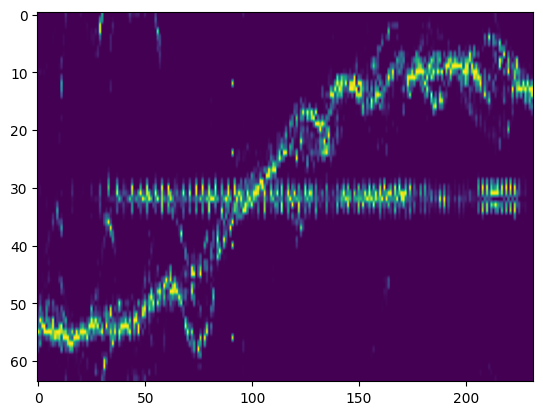

In [8]:
if __name__ == "__main__":
    ## EXAMPLE USAGE

    # This static method generates and saves files in DATA_PATH_V2, 
    # using the raw data in RAW_DATA_PATH.
    # These files are then to be used by the Pytorch dataset in the __get_item__ method
    # NB: takes a long time to run
    os.makedirs(DATA_PATH_V2, exist_ok=True)

    #dataset.Sparse_MD_Dataset_V2.generate_dataset(out_folder=DATA_PATH_V2)

    # This static method generates the train, valid and test filenames lists
    train_fnames, valid_fnames, test_fnames = dataset.Sparse_MD_Dataset_V2.make_splits(
        SUBJECTS, ACTIVITIES, sparse_dataset_path=DATA_PATH_V2
    )

    # Build dataset objects
    train_set = dataset.Sparse_MD_Dataset_V2(train_fnames)
    valid_set = dataset.Sparse_MD_Dataset_V2(valid_fnames)
    test_set = dataset.Sparse_MD_Dataset_V2(test_fnames)

    for (X,  mD_columns, Y) in train_set:
        # This dataset returns three elements:
        # X: the raw data,
        # IHT_output: the output of the IHT algorithm (you don't need it)
        # mD_columns: the mD spectrum
        print(X.shape, mD_columns.shape, Y)

        # You can plot the mD spectrum like this:
        plt.imshow(mD_columns.T, aspect="auto")
        plt.show()
        break

In [4]:
n_win_train = [X[0].shape[0] for X in train_set]
n_win_valid = [X[0].shape[0] for X in valid_set]
n_win_test = [X[0].shape[0] for X in test_set]

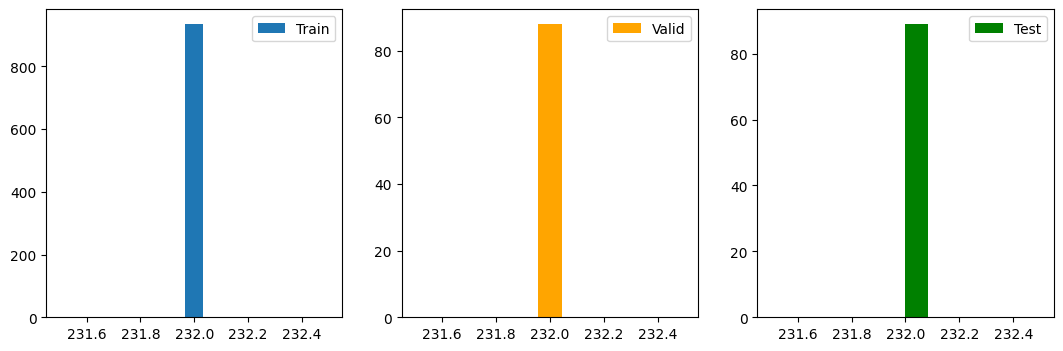

In [5]:
plt.subplots(1,3, figsize=(13,4))

plt.subplot(131)
plt.hist(n_win_train, bins=15, label="Train")
plt.legend()
plt.subplot(132)
plt.hist(n_win_valid, bins=11, label="Valid", color='orange')
plt.legend()
plt.subplot(133)
plt.hist(n_win_test, bins=12, label='Test', color='green')
plt.legend()
plt.show()

In [9]:
torch.save(train_set, 'data/train_dataset.pt')
torch.save(valid_set, 'data/val_dataset.pt')
torch.save(test_set, 'data/test_dataset.pt')

In [7]:
train_fnames_ = [name.split('_')[2] for name in train_fnames]
valid_fnames_ = [name.split('_')[2] for name in valid_fnames]
test_fnames_ = [name.split('_')[2] for name in test_fnames]

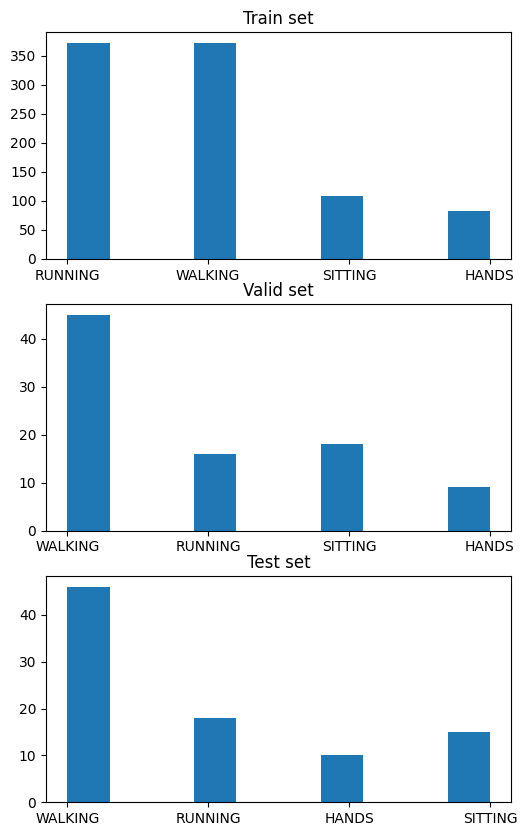

In [8]:
fig, axs = plt.subplots(3, figsize=(6, 10))
axs[0].hist(train_fnames_)
axs[0].set_title("Train set")
axs[1].hist(valid_fnames_)
axs[1].set_title("Valid set")
axs[2].hist(test_fnames_)
axs[2].set_title("Test set")

plt.show()

## Correlation between real and imaginary part of the CIR windows

In [7]:
corr_signal = []

for (X, muD, y) in tqdm(train_set):
    
    for w in range(X.shape[1]):
    
        for r in range(X.shape[2]):

            corr_signal.append(np.corrcoef(X[0,w,r,:], X[1,w,r ,:])[0,1])

  0%|          | 0/935 [00:00<?, ?it/s]

100%|██████████| 935/935 [02:27<00:00,  6.33it/s]


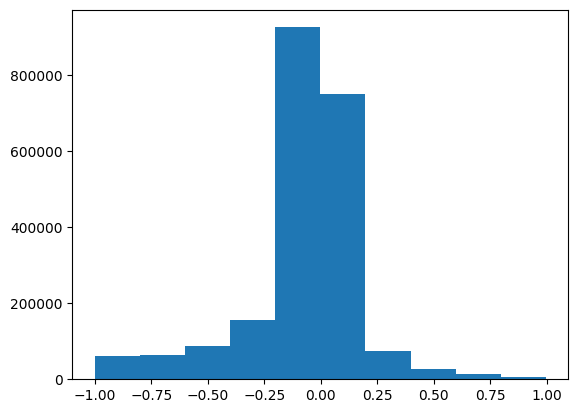

In [34]:
plt.hist(corr_signal)
plt.show()